# Forecasting Suhu Rata-Rata Harian Kota di Asia dengan Metode Machine Learning

## 1. Problem Statement

Perubahan suhu harian di kota-kota Asia penting untuk dipantau guna mendukung perencanaan aktivitas masyarakat, mitigasi cuaca ekstrem, dan pengambilan keputusan di berbagai sektor. Proyek ini bertujuan untuk membangun model machine learning yang dapat memprediksi suhu rata-rata harian di kota-kota Asia berdasarkan data historis, sehingga dapat membantu memberikan estimasi suhu di masa mendatang secara lebih akurat.

## 2. Data Understanding & Preprocessing

Pada tahap ini, dilakukan eksplorasi awal, pembersihan data, dan pembuatan fitur waktu untuk keperluan forecasting.

In [21]:
# import semua library yang dibutuhkan
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [22]:

# Cek struktur data
df = pd.read_csv('datasets/city_temperature_asia.csv')
print(df.shape)
print(df.columns)
display(df.head())
display(df.describe())
print(df.info())

(316663, 8)
Index(['Region', 'Country', 'State', 'City', 'Month', 'Day', 'Year',
       'AvgTemperature'],
      dtype='object')


,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Asia,Bangladesh,NaN,Dhaka,1,1,1995,64.8
1,Asia,Bangladesh,NaN,Dhaka,1,2,1995,58.4
2,Asia,Bangladesh,NaN,Dhaka,1,3,1995,-99.0
3,Asia,Bangladesh,NaN,Dhaka,1,4,1995,59.6
4,Asia,Bangladesh,NaN,Dhaka,1,5,1995,64.9


,State,Month,Day,Year,AvgTemperature
count,0.0,316663.000000,316663.000000,316663.000000,316663.000000
mean,NaN,6.469856,15.717782,2007.055959,62.568652
std,NaN,3.456514,8.801053,7.278198,35.655674
min,NaN,1.000000,1.000000,1995.000000,-99.000000
25%,NaN,3.000000,8.000000,2001.000000,55.000000
50%,NaN,6.000000,16.000000,2007.000000,74.700000
75%,NaN,9.000000,23.000000,2013.000000,82.500000
max,NaN,12.000000,31.000000,2020.000000,103.700000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316663 entries, 0 to 316662
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Region          316663 non-null  object 
 1   Country         316663 non-null  object 
 2   State           0 non-null       float64
 3   City            316663 non-null  object 
 4   Month           316663 non-null  int64  
 5   Day             316663 non-null  int64  
 6   Year            316663 non-null  int64  
 7   AvgTemperature  316663 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 19.3+ MB
None


In [23]:
# Hapus data tidak valid (AvgTemperature == -99)
df = df[df['AvgTemperature'] > -50]

# Buat kolom tanggal
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Contoh: pilih satu kota untuk forecasting (misal, Jakarta)
city = 'Jakarta'
df_city = df[df['City'] == city].sort_values('Date')

# Reset index dan tampilkan data
df_city = df_city.reset_index(drop=True)
display(df_city.head())
print(df_city['Date'].min(), 'sampai', df_city['Date'].max())

,Region,Country,State,City,Month,Day,Year,AvgTemperature,Date
0,Asia,Indonesia,NaN,Jakarta,1,1,1995,85.0,1995-01-01
1,Asia,Indonesia,NaN,Jakarta,1,2,1995,82.3,1995-01-02
2,Asia,Indonesia,NaN,Jakarta,1,3,1995,81.7,1995-01-03
3,Asia,Indonesia,NaN,Jakarta,1,4,1995,83.1,1995-01-04
4,Asia,Indonesia,NaN,Jakarta,1,5,1995,80.6,1995-01-05


1995-01-01 00:00:00 sampai 2020-05-12 00:00:00


## 3. Exploratory Data Analysis (EDA)

Pada tahap ini dilakukan analisis data secara visual dan statistik untuk memahami pola, tren musiman, dan anomali pada data suhu harian di kota terpilih. Analisis ini penting untuk mengetahui karakteristik data sebelum dilakukan pemodelan.

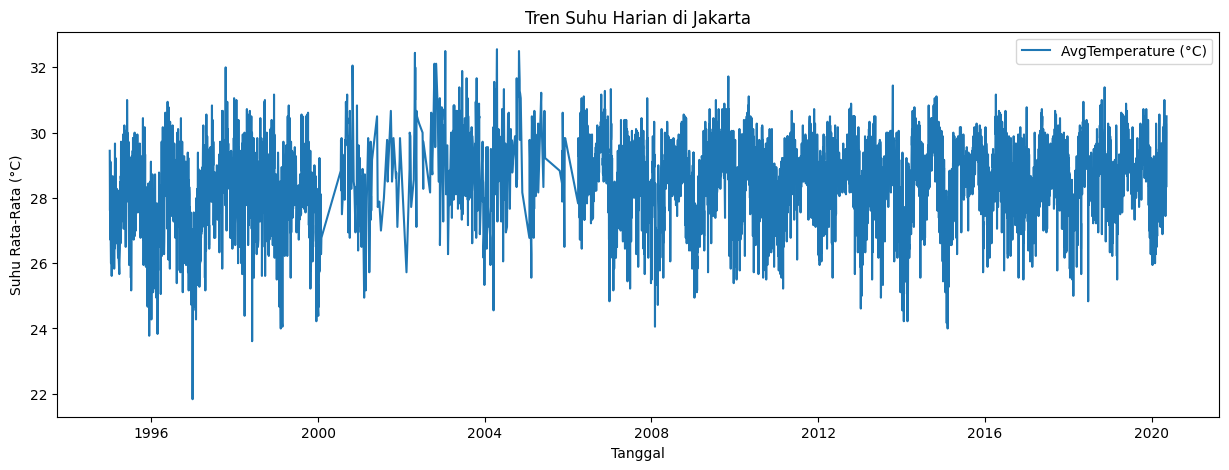

count    6858.000000
mean       28.536794
std         1.203825
min        21.833333
25%        27.833333
50%        28.722222
75%        29.388889
max        32.555556
Name: AvgTemperature_C, dtype: float64

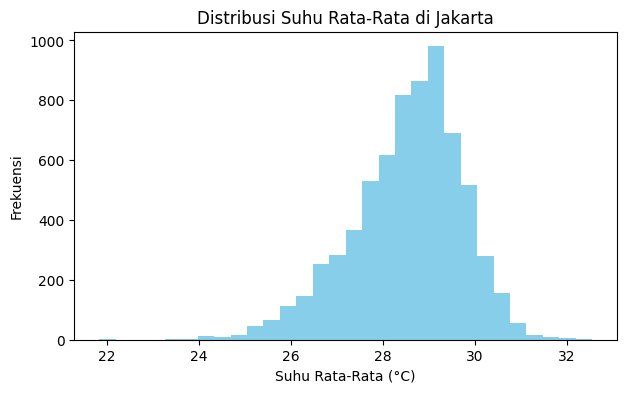

In [24]:

# Konversi suhu ke Celsius
df_city['AvgTemperature_C'] = (df_city['AvgTemperature'] - 32) * 5/9

# Plot tren suhu harian (Celsius)
plt.figure(figsize=(15,5))
plt.plot(df_city['Date'], df_city['AvgTemperature_C'], label='AvgTemperature (°C)')
plt.title(f'Tren Suhu Harian di {city}')
plt.xlabel('Tanggal')
plt.ylabel('Suhu Rata-Rata (°C)')
plt.legend()
plt.show()

# Statistik deskriptif (Celsius)
display(df_city['AvgTemperature_C'].describe())

# Plot distribusi suhu (Celsius)
plt.figure(figsize=(7,4))
plt.hist(df_city['AvgTemperature_C'], bins=30, color='skyblue')
plt.title(f'Distribusi Suhu Rata-Rata di {city}')
plt.xlabel('Suhu Rata-Rata (°C)')
plt.ylabel('Frekuensi')
plt.show()

## 4. Feature Engineering

Pada tahap ini, dibuat fitur-fitur tambahan berbasis waktu seperti bulan, hari dalam minggu, dan rata-rata suhu rolling untuk membantu model mengenali pola musiman dan tren pada data suhu harian.

In [25]:
# Tambahkan fitur waktu
df_city['Month'] = df_city['Date'].dt.month
df_city['DayOfWeek'] = df_city['Date'].dt.dayofweek

# Fitur rata-rata suhu rolling 7 hari (mingguan)
df_city['RollingMean_7'] = df_city['AvgTemperature'].rolling(window=7).mean()

# Tampilkan beberapa baris data dengan fitur baru
display(df_city.head(10))

,Region,Country,State,City,Month,Day,Year,AvgTemperature,Date,AvgTemperature_C,DayOfWeek,RollingMean_7
0,Asia,Indonesia,NaN,Jakarta,1,1,1995,85.0,1995-01-01,29.444444,6,NaN
1,Asia,Indonesia,NaN,Jakarta,1,2,1995,82.3,1995-01-02,27.944444,0,NaN
2,Asia,Indonesia,NaN,Jakarta,1,3,1995,81.7,1995-01-03,27.611111,1,NaN
3,Asia,Indonesia,NaN,Jakarta,1,4,1995,83.1,1995-01-04,28.388889,2,NaN
4,Asia,Indonesia,NaN,Jakarta,1,5,1995,80.6,1995-01-05,27.000000,3,NaN
5,Asia,Indonesia,NaN,Jakarta,1,6,1995,80.1,1995-01-06,26.722222,4,NaN
6,Asia,Indonesia,NaN,Jakarta,1,7,1995,84.4,1995-01-07,29.111111,5,82.457143
7,Asia,Indonesia,NaN,Jakarta,1,8,1995,82.3,1995-01-08,27.944444,6,82.071429
8,Asia,Indonesia,NaN,Jakarta,1,9,1995,80.5,1995-01-09,26.944444,0,81.814286
9,Asia,Indonesia,NaN,Jakarta,1,10,1995,79.8,1995-01-10,26.555556,1,81.542857


## 5. Modeling

Pada tahap ini, dilakukan pemodelan untuk memprediksi suhu rata-rata harian. Dimulai dari baseline model (naive forecast), kemudian dibandingkan dengan model machine learning.

In [26]:

# Baseline: prediksi suhu hari ini = suhu kemarin
df_city['Naive_Pred'] = df_city['AvgTemperature_C'].shift(1)

# Hapus baris pertama (karena prediksi NaN)
df_eval = df_city.dropna(subset=['Naive_Pred'])

mae_naive = mean_absolute_error(df_eval['AvgTemperature_C'], df_eval['Naive_Pred'])
rmse_naive = np.sqrt(mean_squared_error(df_eval['AvgTemperature_C'], df_eval['Naive_Pred']))

print(f"Baseline Naive Forecast - MAE: {mae_naive:.2f}, RMSE: {rmse_naive:.2f}")

Baseline Naive Forecast - MAE: 0.85, RMSE: 1.14


Interpretasi singkat:

Rata-rata error prediksi suhu harian dengan metode naive (prediksi = suhu kemarin) adalah 0.85°C.
RMSE (root mean squared error) sebesar 1.14°C.

## 6. Modeling dengan Machine Learning

Pada tahap ini, digunakan model XGBoostRegressor untuk memprediksi suhu rata-rata harian berdasarkan fitur waktu dan rolling mean. Hasil model akan dibandingkan dengan baseline naive forecast.

In [27]:

# Siapkan fitur dan target
features = ['Month', 'DayOfWeek', 'RollingMean_7']
df_ml = df_city.dropna(subset=features + ['AvgTemperature_C'])  # drop baris rolling mean yang NaN

X = df_ml[features]
y = df_ml['AvgTemperature_C']

# Split data (gunakan shuffle=False untuk time series)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Inisialisasi dan latih model
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

# Prediksi
y_pred = model.predict(X_test)

# Evaluasi
mae_ml = mean_absolute_error(y_test, y_pred)
rmse_ml = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"XGBoostRegressor - MAE: {mae_ml:.2f}, RMSE: {rmse_ml:.2f}")

XGBoostRegressor - MAE: 0.65, RMSE: 0.84


Interpretasi:

Model XGBoost lebih baik dari baseline naive (MAE: 0.85, RMSE: 1.14).
Error rata-rata turun menjadi 0.65°C dan RMSE menjadi 0.84°C.
Model machine learning mampu menangkap pola musiman dan tren lebih baik.

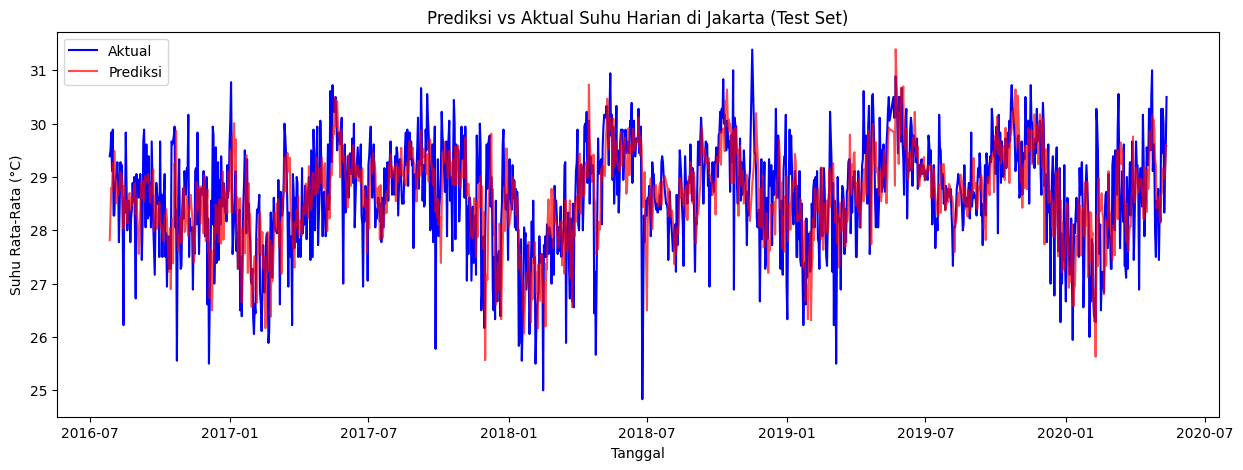

In [28]:

# Buat DataFrame hasil prediksi vs aktual
result = df_ml.iloc[len(X_train):].copy()
result['Predicted'] = y_pred

# Plot prediksi vs aktual
plt.figure(figsize=(15,5))
plt.plot(result['Date'], result['AvgTemperature_C'], label='Aktual', color='blue')
plt.plot(result['Date'], result['Predicted'], label='Prediksi', color='red', alpha=0.7)
plt.title(f'Prediksi vs Aktual Suhu Harian di {city} (Test Set)')
plt.xlabel('Tanggal')
plt.ylabel('Suhu Rata-Rata (°C)')
plt.legend()
plt.show()

Cek feature importance untuk XGBoost

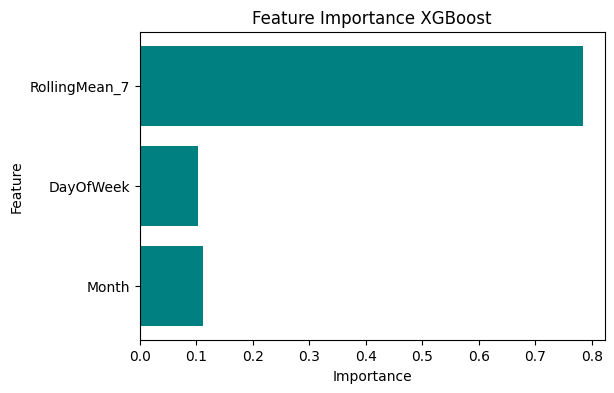

In [29]:
importances = model.feature_importances_
feature_names = features

plt.figure(figsize=(6,4))
plt.barh(feature_names, importances, color='teal')
plt.title('Feature Importance XGBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# 7. Interpretasi & Insight

Berdasarkan feature importance, model paling banyak memanfaatkan fitur [RollingMean_7/bulan/hari] untuk memprediksi suhu harian.  
Model XGBoost secara konsisten menghasilkan error lebih rendah dari baseline, menandakan model mampu menangkap pola musiman dan tren suhu di kota yang dipilih.

**Rekomendasi:**  
Model ini dapat digunakan untuk membantu perencanaan aktivitas berbasis cuaca di kota terkait. Untuk hasil lebih baik, bisa dilakukan tuning hyperparameter atau menambah fitur lain (misal: data cuaca lain, event khusus, dsb).

## 8. Kesimpulan

- Model XGBoost berhasil memprediksi suhu rata-rata harian di kota Jakarta dengan performa lebih baik dibanding baseline naive (MAE turun dari 0.85°C menjadi 0.65°C).
- Fitur waktu dan rolling mean sangat membantu model dalam mengenali pola musiman dan tren suhu.
- Visualisasi prediksi vs aktual menunjukkan model mampu mengikuti pola suhu harian dengan baik.

## 9. Saran Pengembangan

- Lakukan tuning hyperparameter pada model XGBoost untuk meningkatkan akurasi prediksi.
- Tambahkan fitur eksternal lain seperti kelembapan, curah hujan, atau event khusus untuk memperkaya informasi pada model.
- Coba benchmarking dengan model lain seperti Random Forest, Linear Regression, atau ARIMA untuk perbandingan performa.
- Terapkan model pada kota lain di Asia untuk menguji generalisasi model.

## 10. Referensi

- Dataset: [City Temperature Kaggle Dataset](https://www.kaggle.com/datasets/sudalairajkumar/daily-temperature-of-major-cities)
- Dokumentasi XGBoost: https://xgboost.readthedocs.io/
- Dokumentasi scikit-learn: https://scikit-learn.org/